# Time-Frequency Analysis 2.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyxdf
import mne
import pandas as pd


from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from helpers import *



### Local Constants

In [2]:
EVENTS_IDS = {
    'MI' : ['Left','Right','Third'],
    'PO' : [2,5,8]
}

### Local Functions

In [3]:
def get_evoked(EEG_dict):
    evoked_dict = dict()
    eeg_montage = mne.channels.read_custom_montage(MONTAGE)
    for condition in list(EEG_dict.keys()):
        epochs = EEG_dict[condition]['epochs']
        if epochs != None:
            event_type = [key for key in list(EVENTS_IDS.keys()) if key in condition][0];
            events = EVENTS_IDS[event_type]
            evoked = dict()
            for event in events:
                evoked_event = epochs[event].average()
                evoked_event.info.set_montage(eeg_montage)
                evoked[event] = evoked_event

            evoked_dict[condition] = evoked
    
    return evoked_dict

In [4]:
EEG_dict,EEG_dict_epoched = get_subject(2)

Processing: Data/Group_Realistic_Arm/S02
Creating RawArray with float64 data, n_channels=64, n_times=270017
    Range : 0 ... 270016 =      0.000 ...   135.008 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    3.3s finished


Subject: sub-S02, EVENT: Baseline
Creating RawArray with float64 data, n_channels=64, n_times=269026
    Range : 0 ... 269025 =      0.000 ...   134.512 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    3.5s finished


Subject: sub-S02, EVENT: Baseline


Stream 3: Calculated effective sampling rate 4369.2772 Hz is different from specified rate 500.0000 Hz.
Stream 1: Calculated effective sampling rate 12901.4323 Hz is different from specified rate 500.0000 Hz.


Creating RawArray with float64 data, n_channels=64, n_times=1530474
    Range : 0 ... 1530473 =      0.000 ...   765.236 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   10.9s finished


Subject: sub-S02, EVENT: MI
Used Annotations descriptions: ['Left', 'Right', 'Third']
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)


Stream 1: Calculated effective sampling rate 4797.1930 Hz is different from specified rate 500.0000 Hz.
Stream 3: Calculated effective sampling rate 14164.9345 Hz is different from specified rate 500.0000 Hz.


Creating RawArray with float64 data, n_channels=64, n_times=1292072
    Range : 0 ... 1292071 =      0.000 ...   646.035 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   10.3s finished


Subject: sub-S02, EVENT: MI
Used Annotations descriptions: ['Left', 'Right', 'Third']
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)


Stream 4: Calculated effective sampling rate 573.9488 Hz is different from specified rate 999.9999 Hz.


Creating RawArray with float64 data, n_channels=64, n_times=1734061
    Range : 0 ... 1734060 =      0.000 ...   867.030 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   12.7s finished


Subject: sub-S02, EVENT: PO
Used Annotations descriptions: ['2', '5', '8']
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)
Reading Data/Group_Realistic_Arm/S02/ICA_data/sub-S02_eegBaselineCE_ica ...
Now restoring ICA solution ...
Ready.
Reading Data/Group_Realistic_Arm/S02/ICA_data/sub-S02_eegBaselineOE_ica ...
Now restoring ICA solution ...
Ready.
Reading Data/Group_Realistic_Arm/S02/ICA_data/sub-S02_MIpost_ica ...
Now restoring ICA solution ...
Ready.
Reading Data/Group_Realistic_Arm/S02/ICA_data/sub-S02_MIpre_ica ...
Now restoring ICA solution ...
Ready.
Reading Data/Group_Realistic_Arm/S02/ICA_data/sub-S02_PO_ica ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance


c:\Users\haiou\Documents\TNE\Python\helpers.py:423: RuntimeWarning: This filename (Data/Group_Realistic_Arm/S02/ICA_data/sub-S02_eegBaselineCE_ica) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ICA_dict[condition] = mne.preprocessing.read_ica(path+'/ICA_data/'+condition+'_ica')
c:\Users\haiou\Documents\TNE\Python\helpers.py:423: RuntimeWarning: This filename (Data/Group_Realistic_Arm/S02/ICA_data/sub-S02_eegBaselineOE_ica) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ICA_dict[condition] = mne.preprocessing.read_ica(path+'/ICA_data/'+condition+'_ica')
c:\Users\haiou\Documents\TNE\Python\helpers.py:423: RuntimeWarning: This filename (Data/Group_Realistic_Arm/S02/ICA_data/sub-S02_MIpost_ica) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ICA_dict[condition] = mn

    Transforming to ICA space (25 components)
    Zeroing out 1 ICA component
    Projecting back using 59 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 1 ICA component
    Projecting back using 59 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components
    Projecting back using 59 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata

In [5]:
evoked_dict = get_evoked(EEG_dict_epoched)

C:\Users\haiou\AppData\Local\Temp\ipykernel_15612\434609824.py:12: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked_event.info.set_montage(eeg_montage)
C:\Users\haiou\AppData\Local\Temp\ipykernel_15612\434609824.py:12: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked_event.info.set_montage(eeg_montage)
C:\Users\haiou\AppData\Local\Temp\ipykernel_15612\434609824.py:12: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked_event.info.set_montage(eeg_montage)
C:\Users\haiou\AppData\Local\Temp\ipykernel_15612\434609824.py:12: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked_event.info.set_montage(eeg_montage)
C:\Users\haiou\AppData\Local\Temp\ipykernel_15612\434609824.py:12: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transforma

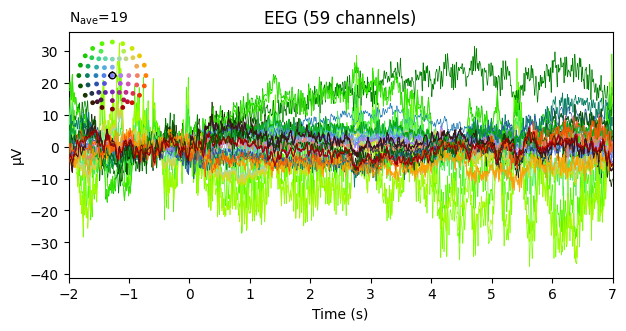

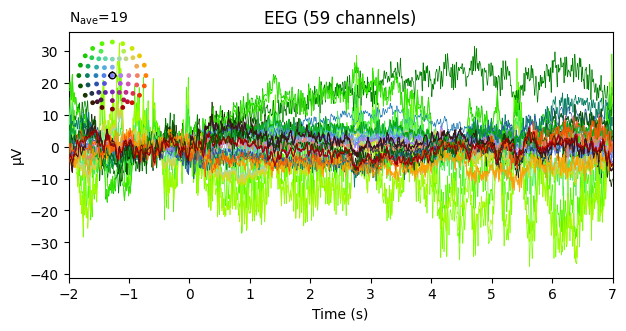

In [41]:
evoked_dict['sub-S02_MIpost']['Left'].plot()

In [6]:
freqs = np.arange(2, 36)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-2, 0)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test
tmin, tmax = -2, 7
epochs_MI = EEG_dict_epoched['sub-S02_MIpost']['epochs'].copy().pick_channels(['C1', 'C2', 'C3', 'Cz', 'C4', 'C5', 'C6'])

In [9]:
tfr = tfr_multitaper(epochs_MI , freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   26.9s finished


Not setting metadata


In [10]:
tfr.crop(-2, 7).apply_baseline(baseline, mode="percent")

Applying baseline correction (mode: percent)


<EpochsTFR | time : [-2.000000, 7.000000], freq : [2.000000, 35.000000], epochs : 51, channels : 6, ~714.5 MB>

In [11]:
df = tfr.to_data_frame(time_format = None, long_format = True)

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


In [23]:
# Map to frequency bands:
freq_bounds = {'_': 0,
               'delta': 3,
               'theta': 7,
               'alpha': 13,
               'beta': 30,
               'gamma' : 35}
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])

In [24]:
# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ['alpha', 'beta','theta','gamma']
df = df[df.band.isin(freq_bands_of_interest)]
df['band'] = df['band'].cat.remove_unused_categories()

In [25]:
df.info

<bound method DataFrame.info of          condition epoch  freq  time channel ch_type     value   band
324036        Left     2   8.0  -2.0      C3     eeg -0.733196  alpha
324037        Left     2   8.0  -2.0      C4     eeg -0.778370  alpha
324038        Left     2   8.0  -2.0      C5     eeg -0.405766  alpha
324039        Left     2   8.0  -2.0      C1     eeg -0.310236  alpha
324040        Left     2   8.0  -2.0      C2     eeg -0.470739  alpha
...            ...   ...   ...   ...     ...     ...       ...    ...
93376369     Third    58  30.0   7.0      C4     eeg -0.363138   beta
93376370     Third    58  30.0   7.0      C5     eeg  0.027130   beta
93376371     Third    58  30.0   7.0      C1     eeg  0.039744   beta
93376372     Third    58  30.0   7.0      C2     eeg -0.320758   beta
93376373     Third    58  30.0   7.0      C6     eeg -0.456687   beta

[63349038 rows x 8 columns]>

In [18]:
df['channel'] = df['channel'].cat.reorder_categories(('C1', 'C2', 'C3', 'C4', 'C5', 'C6'),
                                                     ordered=True)

In [19]:
g = sns.FacetGrid(df, row='band', col='channel', margin_titles=True)
g.map(sns.lineplot, 'time', 'value', 'condition', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None, 1.5))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

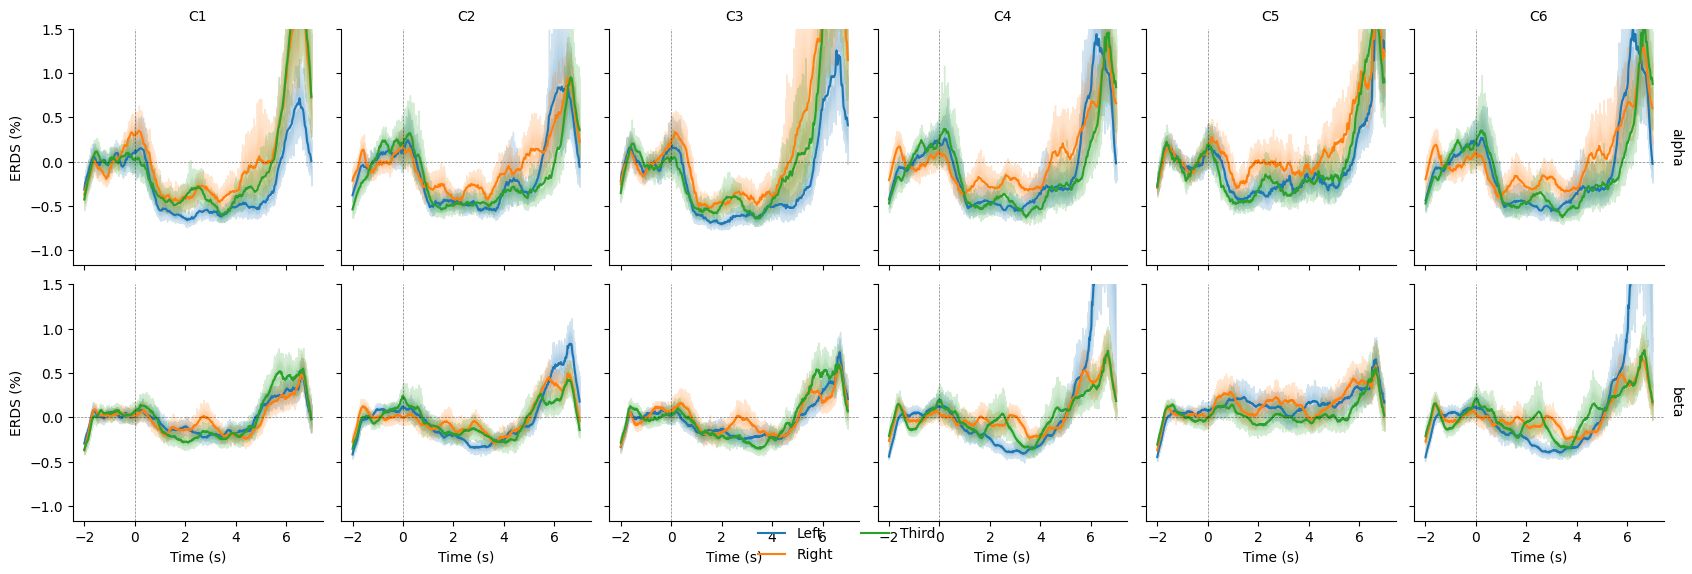

In [20]:
plt.show()

In [52]:
event_ids = EEG_dict_epoched['sub-S02_MIpost']['epochs'].event_id
print(event_ids)

{'Left': 1, 'Right': 2, 'Third': 3}


In [ ]:
epochs = EEG_dict_epoched['sub-S02_MIpost']['epochs']
freqs = np.arange(1.5, 40)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 4, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], cmap="RdBu", cnorm=cnorm, axes=ax,
                              colorbar=False, show=False, mask=mask,
                              mask_style="mask")

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

In [59]:
df = tfr.to_data_frame(time_format = None, long_format = True)
df.head()

In [ ]:
# Map to frequency bands:
freq_bounds = {'_': 0,
               'delta': 3,
               'theta': 7,
               'alpha': 13,
               'beta': 30,}
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])

In [ ]:
# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ['alpha', 'beta']
df = df[df.band.isin(freq_bands_of_interest)]
df['band'] = df['band'].cat.remove_unused_categories()

### Analysis

In [68]:
epochs = EEG_dict_epoched['sub-S02_MIpost']['epochs']
epochs_right = epochs['Right']
evoked_right = epochs_right.average()
eeg_montage = mne.channels.read_custom_montage(MONTAGE)
evoked_right.info.set_montage(eeg_montage)

    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['CP1']
    Rejecting  epoch based on EEG : ['FP1']


C:\Users\haiou\AppData\Local\Temp\ipykernel_14676\1986564033.py:5: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked_right.info.set_montage(eeg_montage)


<Info | 10 non-empty values
 bads: 6 items (EOG, FC2, FC4, M1, M2, EOG)
 ch_names: FP1, FPZ, FP2, F7, F3, FZ, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 64 EEG
 custom_ref_applied: True
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 2000.0 Hz
>

In [72]:
events_type = ['Left','Right','Third']
evoked = dict()
for event in events_type:
    evoked_event = epochs[event].average()
    evoked_event.info.set_montage(eeg_montage)
    evoked[event] = evoked_event

    Rejecting  epoch based on EEG : ['FP1', 'FPZ', 'FP2', 'F7', 'AF7', 'AF3']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FP1']


C:\Users\haiou\AppData\Local\Temp\ipykernel_14676\2289521761.py:5: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked_event.info.set_montage(eeg_montage)


    Rejecting  epoch based on EEG : ['CP1']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['T7', 'P7']
    Rejecting  epoch based on EEG : ['FP1', 'F7', 'AF7']
    Rejecting  epoch based on EEG : ['FP1', 'FPZ', 'FP2']
    Rejecting  epoch based on EEG : ['FP1']


C:\Users\haiou\AppData\Local\Temp\ipykernel_14676\2289521761.py:5: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked_event.info.set_montage(eeg_montage)
C:\Users\haiou\AppData\Local\Temp\ipykernel_14676\2289521761.py:5: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked_event.info.set_montage(eeg_montage)


In [54]:
print(evoked_right.info.ch_names)

['FP1', 'FPZ', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'CZ', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'PZ', 'P4', 'P8', 'POZ', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCZ', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'OZ']


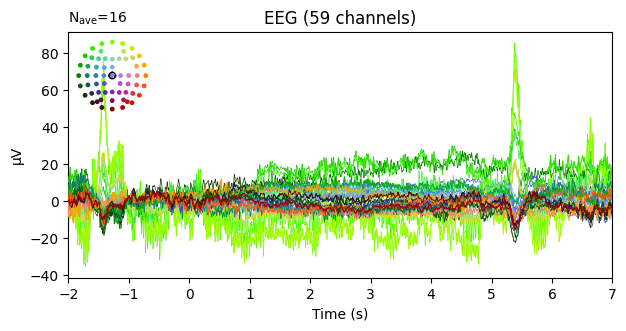

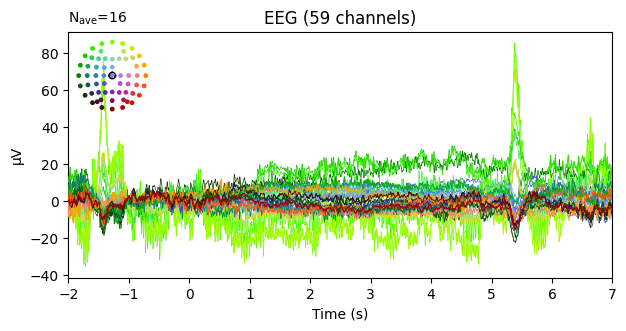

In [83]:
evoked['Third'].plot()

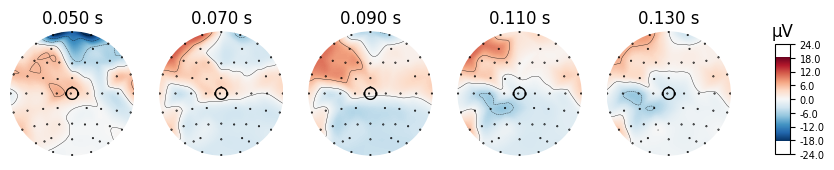

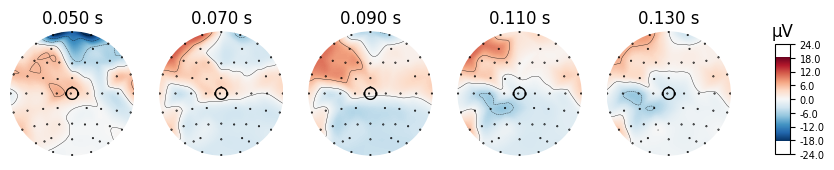

In [82]:
times = np.linspace(0.05, 0.13, 5)
evoked['Third'].plot_topomap(ch_type='eeg', times=times, colorbar=True)

No projector specified for this dataset. Please consider the method self.add_proj.


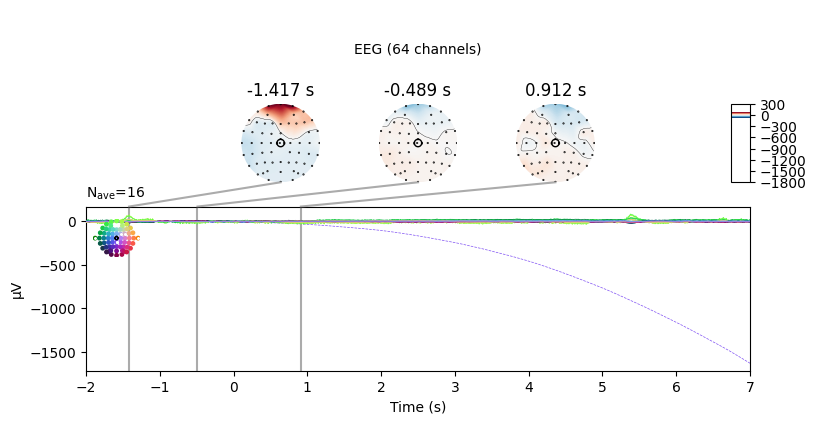

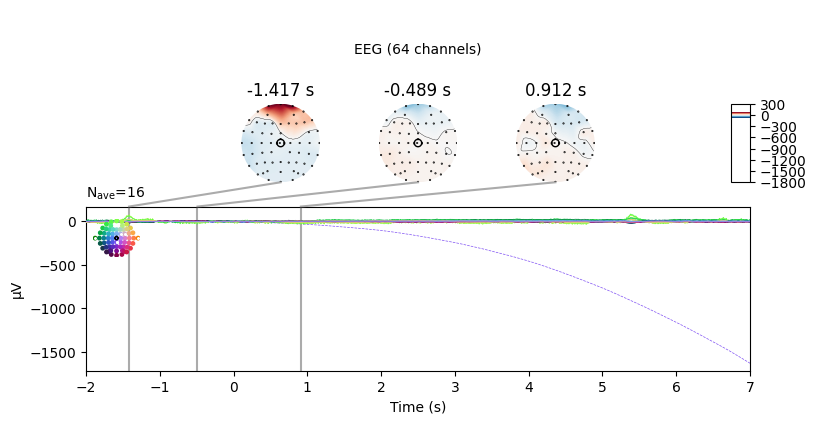

In [81]:
evoked['Third'].plot_joint(exclude=[])

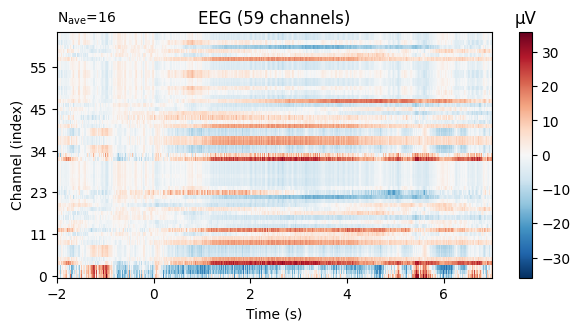

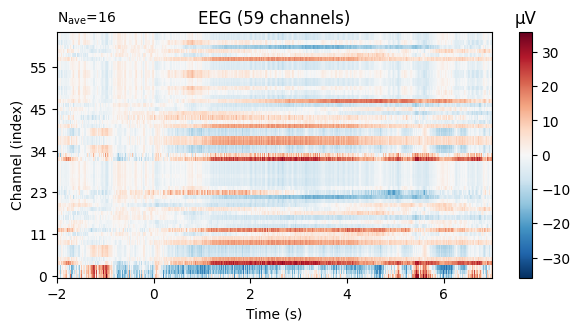

In [53]:
evoked_right.plot_image()

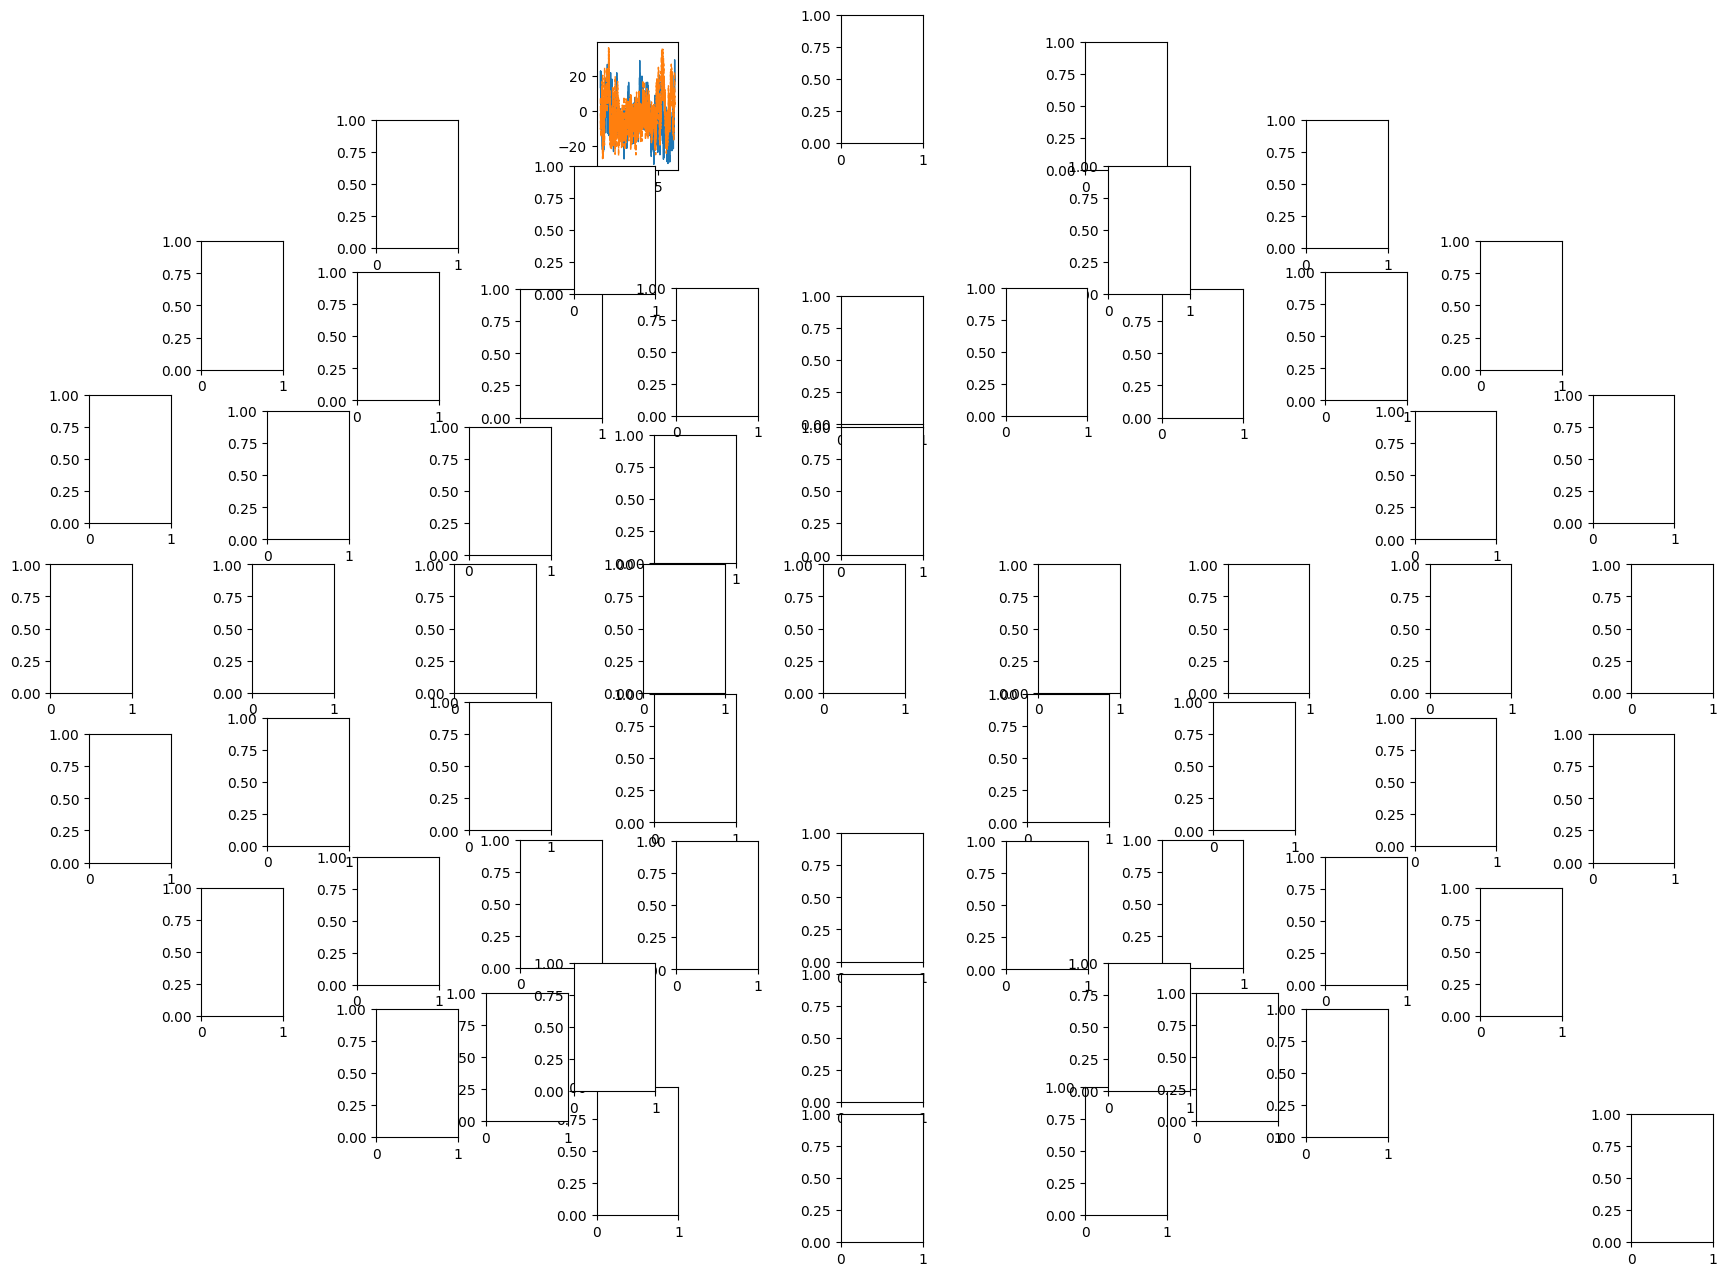

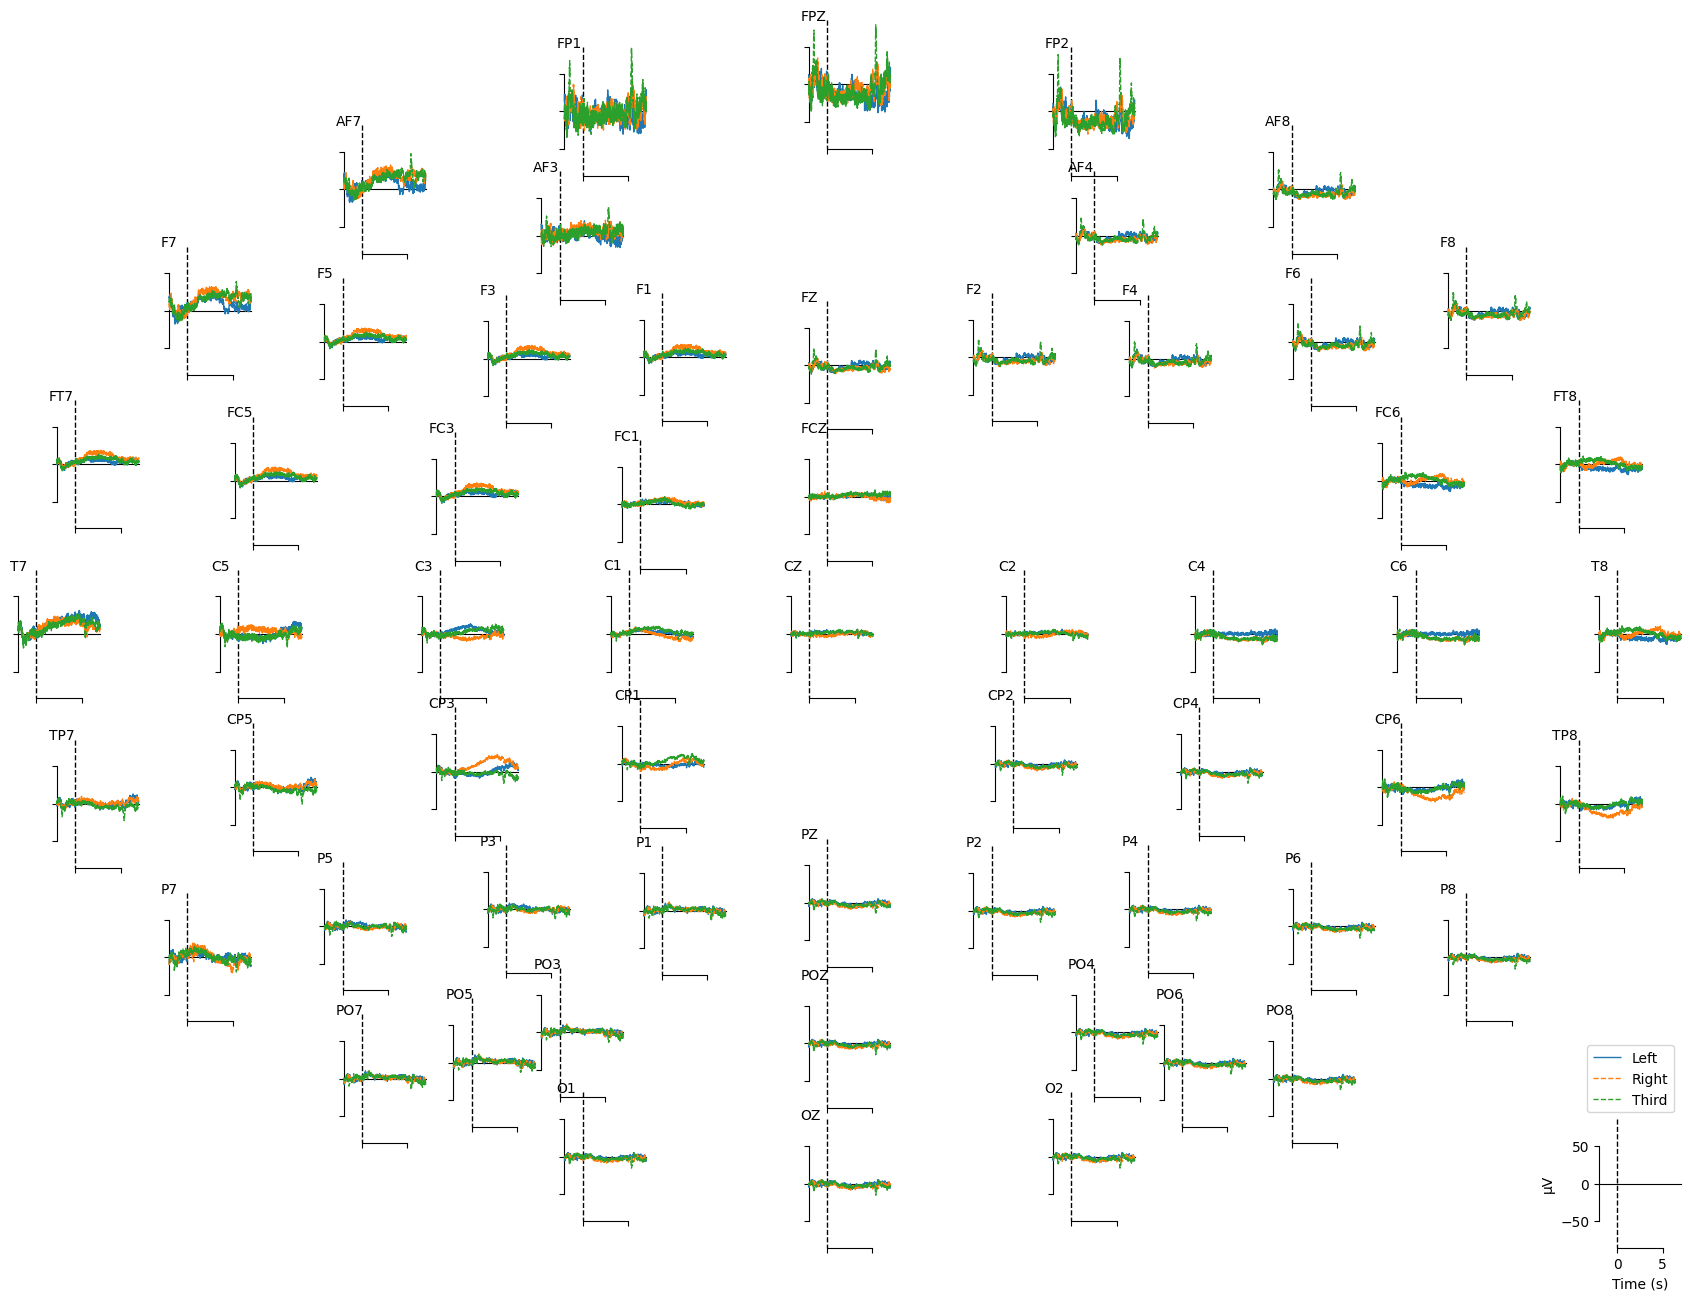

[<Figure size 1800x1400 with 60 Axes>]

In [77]:
mne.viz.plot_compare_evokeds(evoked, picks='eeg', colors=dict(Left=0, Right=1,Third=3),
                             linestyles=dict(Left='solid', Right='dashed',Third='--'),
                             axes='topo', styles=dict(Left=dict(linewidth=1),
                                                      Right=dict(linewidth=1),
                                                      Third=dict(linewidth=1)))

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


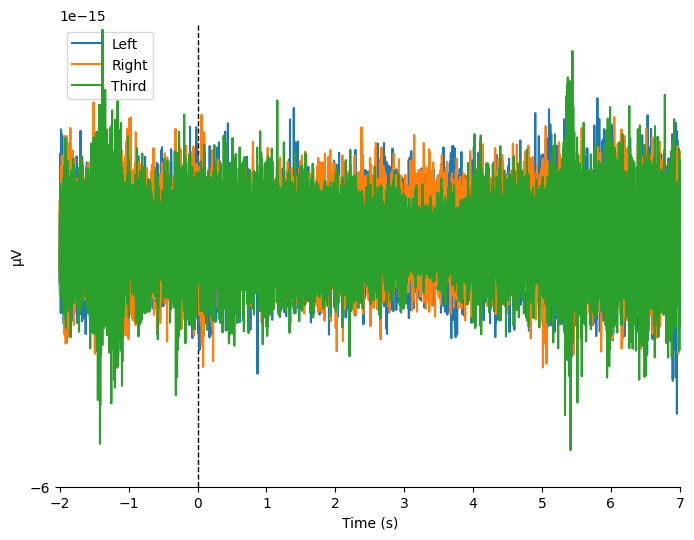

[<Figure size 800x600 with 1 Axes>]

In [85]:
mne.viz.plot_compare_evokeds(evoked,combine='mean')

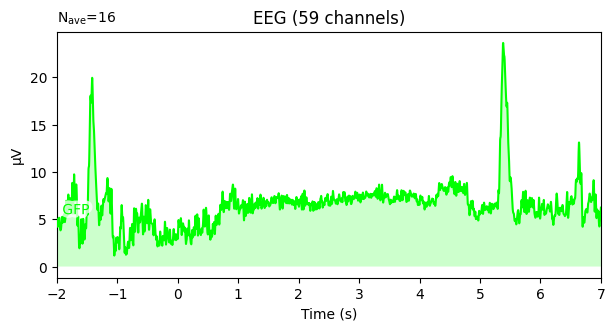

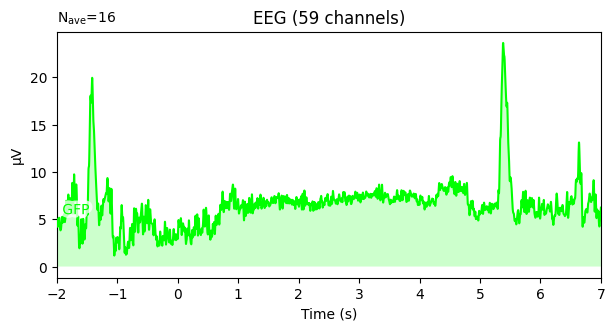

In [80]:
evoked['Third'].plot(gfp='only')

In [24]:
evoked_right.ch_names

['FP1',
 'FPZ',
 'FP2',
 'F7',
 'F3',
 'FZ',
 'F4',
 'F8',
 'FC5',
 'FC1',
 'FC2',
 'FC6',
 'M1',
 'T7',
 'C3',
 'CZ',
 'C4',
 'T8',
 'M2',
 'CP5',
 'CP1',
 'CP2',
 'CP6',
 'P7',
 'P3',
 'PZ',
 'P4',
 'P8',
 'POZ',
 'O1',
 'O2',
 'EOG',
 'AF7',
 'AF3',
 'AF4',
 'AF8',
 'F5',
 'F1',
 'F2',
 'F6',
 'FC3',
 'FCZ',
 'FC4',
 'C5',
 'C1',
 'C2',
 'C6',
 'CP3',
 'CP4',
 'P5',
 'P1',
 'P2',
 'P6',
 'PO5',
 'PO3',
 'PO4',
 'PO6',
 'FT7',
 'FT8',
 'TP7',
 'TP8',
 'PO7',
 'PO8',
 'OZ']

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Using data from preloaded Raw for 20 events and 18001 original time points ...
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['CP1']
    Rejecting  epoch based on EEG : ['FP1']
4 bad epochs dropped
    Using multitaper spectrum estimation with 17 DPSS windows
Averaging across epochs...


c:\Users\haiou\python-env\.venv\env_TNE\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


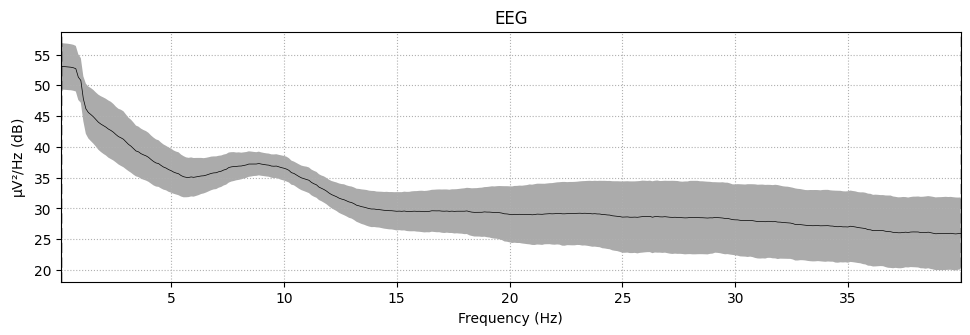

In [14]:
epochs_right.plot_psd(fmin=0.1, fmax=40., average=True, bandwidth=2)

In [ ]:
epochs_right.plot_psd_topomap()

    Rejecting  epoch based on EEG : ['P7']


C:\Users\haiou\AppData\Local\Temp\ipykernel_14676\3142531420.py:3: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked.info.set_montage(eeg_montage)


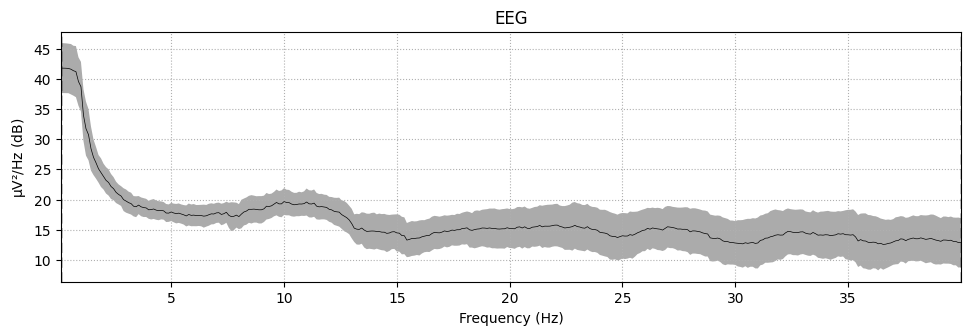

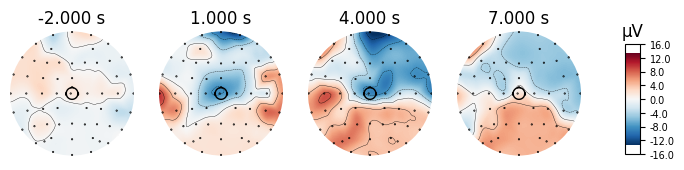

In [9]:
eeg_montage = mne.channels.read_custom_montage(MONTAGE) 
evoked = epochs['5'].average()
evoked.info.set_montage(eeg_montage)
times = np.arange(0.1, 5, 0.8)
evoked.plot_topomap(); 

C:\Users\haiou\AppData\Local\Temp\ipykernel_26588\3567305044.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  evoked_right.plot(spatial_colors=True)


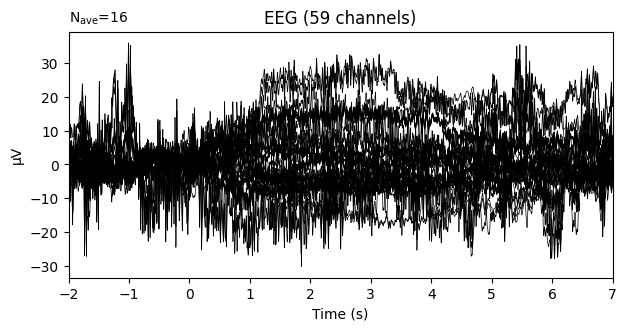

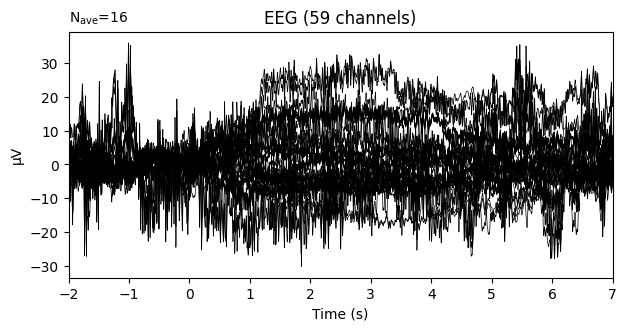

In [30]:
evoked_right.plot(spatial_colors=True)

In [32]:
evoked_right.info.set_montage(get_montage(MONTAGE),on_missing='warn')
evoked_right.plot_topomap(sphere='eeglab')

C:\Users\haiou\AppData\Local\Temp\ipykernel_26588\1408469126.py:1: RuntimeWarning: DigMontage is only a subset of info. There are 1 channel position not present in the DigMontage. The required channels are:

['EOG'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  evoked_right.info.set_montage(get_montage(MONTAGE),on_missing='warn')


ValueError: sphere="eeglab" requires digitization points of the following electrode locations in the data: Fpz, Oz, T7, T8, but could not find: Fpz, and was unable to approximate its location from Oz